In [1]:
# 1. Setup & Libraries

import os
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 🔒 Ensure reproducibility across runs
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["PYTHONHASHSEED"] = str(seed_value)


In [2]:
# 2. Load datasets directly from train / valid / test folders

base_dir = "C:/Users/Kuhn/Desktop/Post-Uni/Data Scientest/Projekte/Tiere"

# Define paths to each subset
train_path = os.path.join(base_dir, "train")
valid_path = os.path.join(base_dir, "valid")
test_path  = os.path.join(base_dir, "test")

# Read annotation CSVs
train_df = pd.read_csv(os.path.join(train_path, "_annotations.csv"))
valid_df = pd.read_csv(os.path.join(valid_path, "_annotations.csv"))
test_df  = pd.read_csv(os.path.join(test_path, "_annotations.csv"))

# Add a binary label column ('dog' / 'cat')
for df, path in zip([train_df, valid_df, test_df], [train_path, valid_path, test_path]):
    df["label"] = df["class"].apply(lambda x: "dog" if "dog" in x else "cat")
    df["filepath"] = df["filename"].apply(lambda x: os.path.join(path, x))

# Quick sanity check
print("Train size:", len(train_df))
print("Validation size:", len(valid_df))
print("Test size:", len(test_df))
print(train_df["label"].value_counts())


Train size: 12899
Validation size: 738
Test size: 368
label
dog    8814
cat    4085
Name: count, dtype: int64


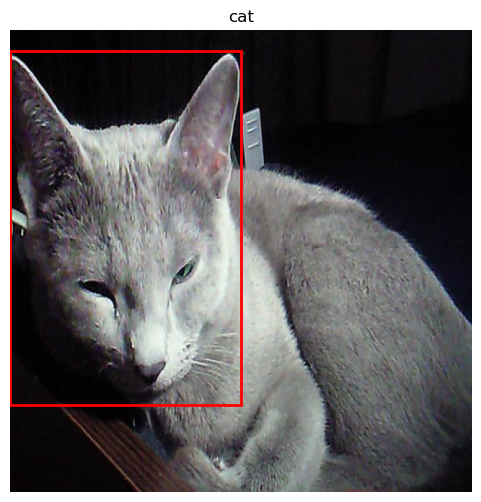

In [4]:
# 3. Visualize an example with annotation box

# pick an example row and plot the image with its annotation box
row = df.iloc[99]
img = Image.open(row["filepath"])

fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(img)
rect = patches.Rectangle(
    (row["xmin"], row["ymin"]),                # top-left corner
    row["xmax"] - row["xmin"],                 # width
    row["ymax"] - row["ymin"],                 # height
    linewidth=2,
    edgecolor="red",
    facecolor="none"
)
ax.add_patch(rect)
plt.title(row["label"])
plt.axis("off")
plt.show()

In [ ]:
# 4. Simple rescaling for all sets
datagen = ImageDataGenerator(rescale=1.0/255.0)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(128, 128),
    class_mode="binary",
    batch_size=32,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col="filepath",
    y_col="label",
    target_size=(128, 128),
    class_mode="binary",
    batch_size=32,
    shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(128, 128),
    class_mode="binary",
    batch_size=32,
    shuffle=False
)


Found 12899 validated image filenames belonging to 2 classes.
Found 738 validated image filenames belonging to 2 classes.
Found 368 validated image filenames belonging to 2 classes.


In [7]:
# 5. Build a simple CNN model for binary classification

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')   # single output neuron for binary classification
])

# compile with a small learning rate for more stable training
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

c:\Users\Kuhn\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 6. Train model (using validation set for monitoring generalization)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


c:\Users\Kuhn\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 145s 356ms/step - accuracy: 0.6891 - loss: 0.5928 - val_accuracy: 0.6816 - val_loss: 0.5811
Epoch 2/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 126s 313ms/step - accuracy: 0.7311 - loss: 0.5266 - val_accuracy: 0.7276 - val_loss: 0.5757
Epoch 3/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 116s 288ms/step - accuracy: 0.7701 - loss: 0.4779 - val_accuracy: 0.7276 - val_loss: 0.5598
Epoch 4/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 135s 334ms/step - accuracy: 0.7976 - loss: 0.4373 - val_accuracy: 0.7466 - val_loss: 0.5593
Epoch 5/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 135s 334ms/step - accuracy: 0.8170 - loss: 0.4024 - val_accuracy: 0.7480 - val_loss: 0.5625
Epoch 6/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 131s 324ms/step - accuracy: 0.8395 - loss: 0.3675 - val_accuracy: 0.7561 - val_loss: 0.5590
Epoch 7/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 132s 328ms/step - accuracy: 0.8508 - loss: 0.3396 - val_accuracy: 0.7412 - val_loss: 0.6098
Epoch 8/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 130s 321ms/step - accuracy: 0.8670 -

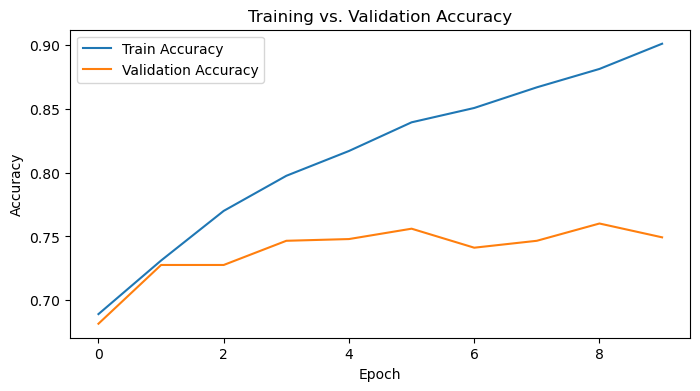

In [9]:
# 7. Plot training and validation accuracy

plt.figure(figsize=(8,4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs. Validation Accuracy")
plt.show()


Evaluating on test set...



c:\Users\Kuhn\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step
Class mapping: {'cat': 0, 'dog': 1}


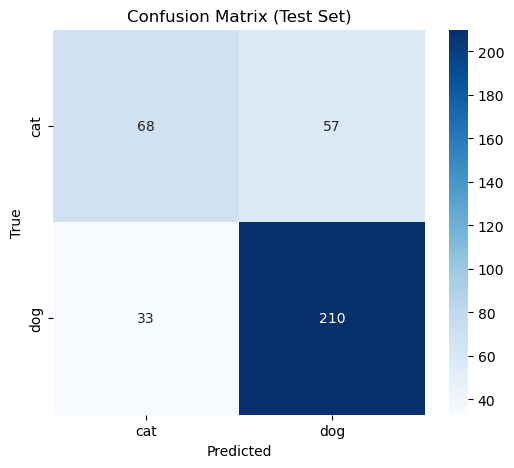

Classification Report (Test Set):

              precision    recall  f1-score   support

         cat       0.67      0.54      0.60       125
         dog       0.79      0.86      0.82       243

    accuracy                           0.76       368
   macro avg       0.73      0.70      0.71       368
weighted avg       0.75      0.76      0.75       368



In [10]:
# 8. Final Evaluation on Test Set

print("\nEvaluating on test set...\n")

# get predicted probabilities for test set
test_gen.reset()
y_pred_prob = model.predict(test_gen, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # sigmoid → binary

# true labels from generator
y_true = test_gen.classes

# get class name mapping
class_indices = test_gen.class_indices
class_names = list(class_indices.keys())
print("Class mapping:", class_indices)

# confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# classification report
print("Classification Report (Test Set):\n")
print(classification_report(y_true, y_pred, target_names=class_names))